In [1]:
!pip install mtcnn
from mtcnn import MTCNN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.5 MB/s eta 0:00:00


In [2]:
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import numpy as np
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode           #confilict occured between two lib
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
import contextlib
import sys

%matplotlib inline

 prevent MTCNN from producing output to maintain a stable screen when using a webcam

In [3]:
class DummyStream:
    def write(self, text):
        pass
    def flush(self):
        pass
dummy_stream = DummyStream()

*MTCNN* detector for face features extraction

In [4]:
detector = MTCNN()
def predict_feature_point_locations(img) :
  with contextlib.redirect_stdout(dummy_stream):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detection = detector.detect_faces(img)
  return detection

isolating the eye region using the provided eye feature points, which consist of the coordinates of the eye centers.

In [5]:
def extract_eye_region(image, eye_center_points):

    right_eye_size = 80
    right_eye_region = image.crop((eye_center_points['right'][0] - right_eye_size // 2, eye_center_points['right'][1] - right_eye_size // 2,
                                   eye_center_points['right'][0] + right_eye_size // 2, eye_center_points['right'][1] + right_eye_size // 2))

    left_eye_size = 80
    left_eye_region = image.crop((eye_center_points['left'][0] - left_eye_size // 2, eye_center_points['left'][1] - left_eye_size // 2,
                                  eye_center_points['left'][0] + left_eye_size // 2, eye_center_points['left'][1] + left_eye_size // 2))


    return right_eye_region, left_eye_region



returns cordinates of eye bounding box given eye center points

In [6]:
def extract_eye_bbox(eye_center_points):
    eye_size = 50
    left=eye_center_points[0] - eye_size // 2
    upper=eye_center_points[1] - eye_size // 2
    right=eye_center_points[0] + eye_size // 2
    lower=eye_center_points[1] + eye_size // 2
    return (left,upper,right,lower)



isolating the mouth region using the provided mouth feature points, which consist of the coordinates of the mouth corners.



In [7]:
def extract_mouth_region(image, left_corner, right_corner):

    d = (left_corner[0] - right_corner[0]) ** 2 + (left_corner[1] - right_corner[1]) ** 2
    width = int(d**0.55)
    height = width

    center_x = (left_corner[0] + right_corner[0]) // 2
    center_y = (left_corner[1] + right_corner[1]) // 2

    left = center_x - width // 2
    upper = center_y - height // 2
    right = left + width
    lower = upper + height

    mouth_region = image.crop((left, upper, right, lower))

    return mouth_region



returns cordinates of mouth bounding box given mouth corner points

In [8]:
def extract_mouth_bbox(mouth_feature_points) :
   d = (mouth_feature_points['left'][0] - mouth_feature_points['right'][0]) ** 2 + (mouth_feature_points['left'][1] - mouth_feature_points['right'][1]) ** 2
   width = int(d ** 0.5)
   height = width
   center_x = (mouth_feature_points['left'][0] + mouth_feature_points['right'][0]) // 2
   center_y = (mouth_feature_points['left'][1] + mouth_feature_points['right'][1]) // 2
   left = center_x - width // 2
   upper = center_y - height // 2
   right = left + width
   lower = upper + height
   return (left,upper,right,lower)

Illustrate feature points and a bounding box on top of an image.

In [9]:
def draw_feature_points_and_bounding_box(image_path, feature_points, bounding_box):

    image = cv2.imread(image_path)

    for (x, y) in feature_points:
        cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

    x, y, w, h = bounding_box
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)

    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

responsible for drawing bounding boxes around the eyes and mouth on the image.

In [10]:
def draw_mouth_eye_bounding_boxes(image, eye_center_points, mouth_corners, color=(255, 255, 255), thickness=2):
    annotated_image = image.copy()

    eye_size = 30

    mouth_size = 50

    # Draw bounding boxes for the eyes
    for eye, center in eye_center_points.items():
        x, y = center
        left_upper_eye = (x - eye_size, y - eye_size)
        right_lower_eye = (x + eye_size, y + eye_size)
        cv2.rectangle(annotated_image, left_upper_eye, right_lower_eye, color, thickness)

    # Draw bounding box for the mouth
    left_mouth_x, left_mouth_y = mouth_corners['left']
    right_mouth_x, right_mouth_y = mouth_corners['right']
    center_x = (left_mouth_x + right_mouth_x) // 2
    center_y = (left_mouth_y + right_mouth_y) // 2
    left_upper_mouth = (center_x - mouth_size, center_y - mouth_size)
    right_lower_mouth = (center_x + mouth_size, center_y + mouth_size)
    cv2.rectangle(annotated_image, left_upper_mouth, right_lower_mouth, color, thickness)
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(annotated_image_rgb)

    return pil_image


#testing model


<h3>drowsy driver

before running following cells,<br>please upload test images *(drowsy_driver.png ,normal_driver.png)* into colab

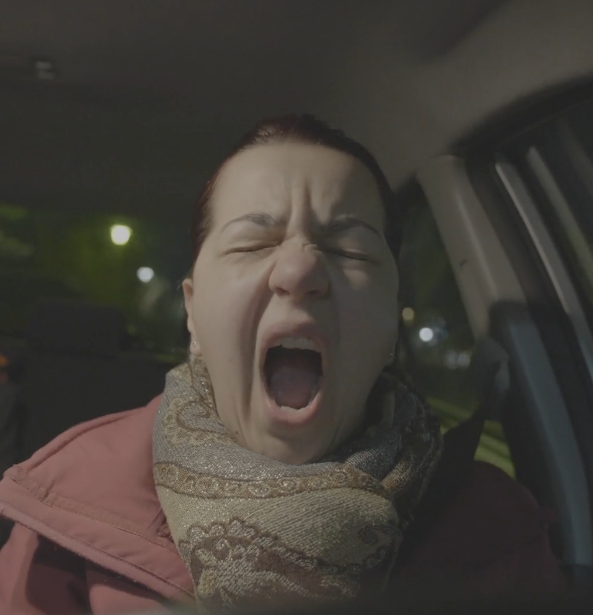

In [11]:
drowsy_driver_path = '/content/drowsy_driver.png'
Image.open(drowsy_driver_path)

Extract face and feature points of test image

In [12]:
feature_points = predict_feature_point_locations(cv2.imread(drowsy_driver_path))[0]
face_bbox = feature_points['box']
keypoints = feature_points['keypoints']

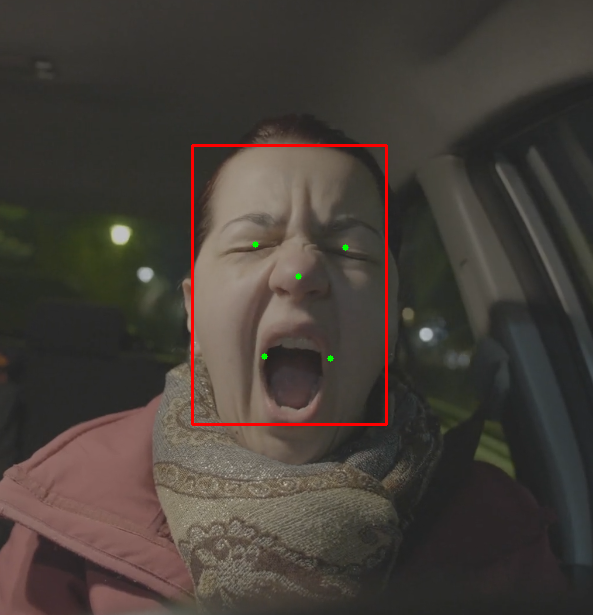

In [13]:
feature_points = keypoints.values()
bounding_box = face_bbox

draw_feature_points_and_bounding_box(drowsy_driver_path, feature_points, bounding_box)

In [14]:
eye_feature_points = {'right':keypoints['right_eye'],'left':keypoints['left_eye']}
mouth_feature_points = {'right':keypoints['mouth_right'],'left':keypoints['mouth_left']}
img = Image.open(drowsy_driver_path)
right_eye_region, left_eye_region = extract_eye_region(img,eye_feature_points)
mouth_region = extract_mouth_region(img,mouth_feature_points['left'],mouth_feature_points['right'])

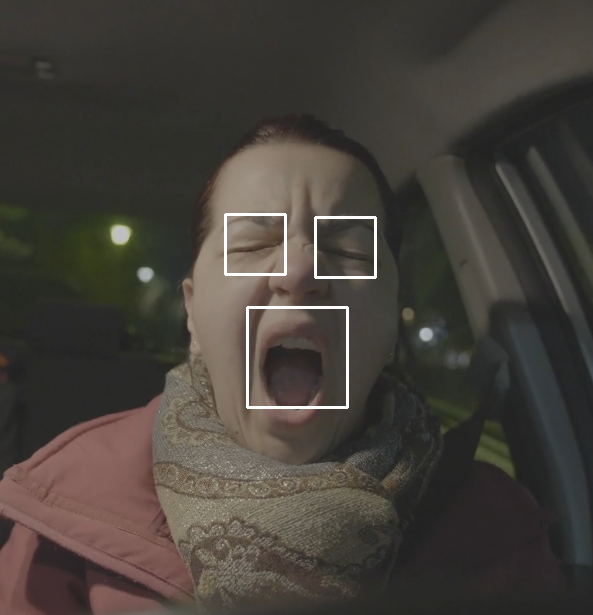

In [15]:
draw_mouth_eye_bounding_boxes(cv2.imread(drowsy_driver_path),eye_feature_points,mouth_feature_points)

before running this cell,please upload EMTCNN.py module and EMTCNN weights (model_weights.hdf5) into colab

In [16]:
from EMTCNN import EMTCNN

In [17]:
model = EMTCNN()

loading model weights

In [18]:
model.model.load_weights('/content/model_weights.hdf5')

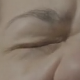

In [19]:
left_eye_region

In [20]:
model.predict_single_image(left_eye_region)


1/1 [==============================] - 0s 354ms/step


('eye close', 0.73014516)

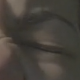

In [21]:
right_eye_region

In [22]:
model.predict_single_image(right_eye_region)

1/1 [==============================] - 0s 65ms/step


('eye close', 0.60453254)

Insufficient data for eyes had led to low confidence. More data collection could have boosted confidence.

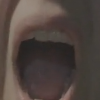

In [23]:
mouth_region

In [24]:
model.predict_single_image(mouth_region)


1/1 [==============================] - 0s 63ms/step


('yawn', 0.8388471)

#normal driver

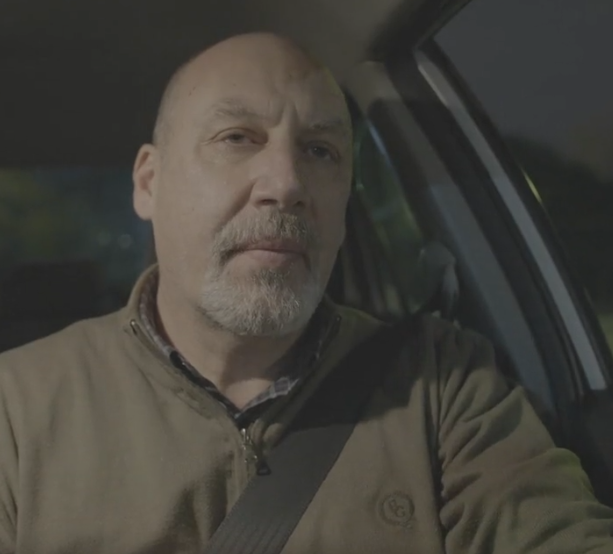

In [25]:
normal_driver_path = '/content/normal_driver.png'

Image.open(normal_driver_path)

In [26]:
feature_points = predict_feature_point_locations(cv2.imread(normal_driver_path))[0]
face_bbox = feature_points['box']
keypoints = feature_points['keypoints']

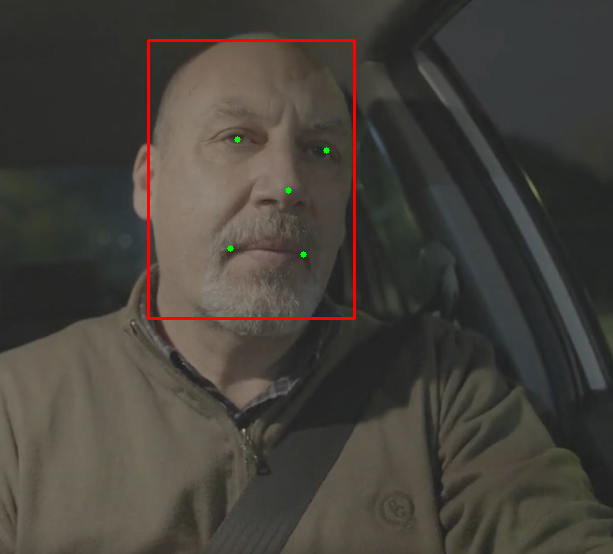

In [27]:
feature_points = keypoints.values()
bounding_box = face_bbox

draw_feature_points_and_bounding_box(normal_driver_path, feature_points, bounding_box)

In [28]:
eye_feature_points = {'right':keypoints['right_eye'],'left':keypoints['left_eye']}
mouth_feature_points = {'right':keypoints['mouth_right'],'left':keypoints['mouth_left']}
img = Image.open(normal_driver_path)
right_eye_region, left_eye_region = extract_eye_region(img,eye_feature_points)
mouth_region = extract_mouth_region(img,mouth_feature_points['left'],mouth_feature_points['right'])

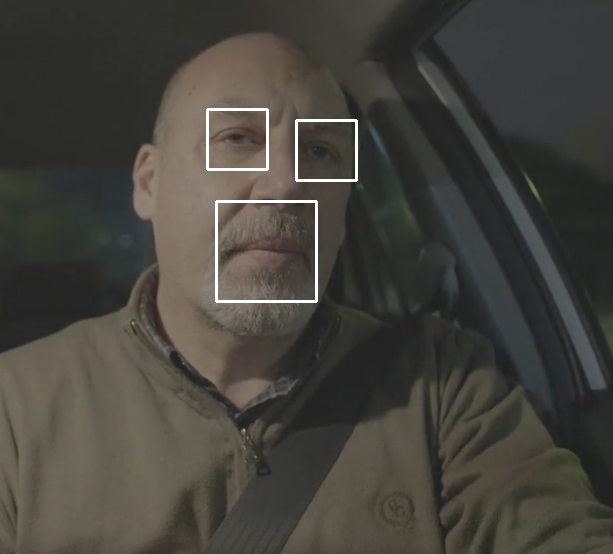

In [29]:
draw_mouth_eye_bounding_boxes(cv2.imread(normal_driver_path),eye_feature_points,mouth_feature_points)

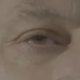

In [30]:
left_eye_region

In [31]:
model.predict_single_image(left_eye_region)


1/1 [==============================] - 0s 73ms/step


('eye open', 0.8701241)

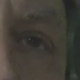

In [32]:
right_eye_region

In [33]:
model.predict_single_image(right_eye_region)

1/1 [==============================] - 0s 59ms/step


('eye open', 0.5542054)

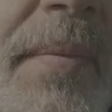

In [34]:
mouth_region

In [35]:
model.predict_single_image(mouth_region)


1/1 [==============================] - 0s 83ms/step


('no yawn', 0.29787904)

This function performs real-time facial feature point detection and status prediction for the eyes and mouth using a given model. It returns the predicted statuses and bounding boxes with scaling ratios.

In [47]:
def predict(img,model,width,height):
  feature_points = predict_feature_point_locations(img)
  if feature_points :
    feature_points = feature_points[0]
    face_bbox = feature_points['box']
    keypoints = feature_points['keypoints']
    eye_feature_points = {'right':keypoints['right_eye'],'left':keypoints['left_eye']}
    mouth_feature_points = {'right':keypoints['mouth_right'],'left':keypoints['mouth_left']}
    right_eye_region, left_eye_region = extract_eye_region(Image.fromarray(img),eye_feature_points)
    mouth_region = extract_mouth_region(Image.fromarray(img),mouth_feature_points['left'],mouth_feature_points['right'])
    right_eye_region.save('eye.jpg')
    mouth_region.save('mouth.jpg')
    mouth_status = model.predict_mouth_state(mouth_region)
    right_eye_status = model.predict_eye_state(right_eye_region)
    left_eye_status = model.predict_eye_state(left_eye_region)
    img_height, img_width, _ = img.shape
    width_ratio = img_width/width
    height_ratio = img_height/height
    return [(right_eye_status[0],right_eye_status[1],extract_eye_bbox(eye_feature_points['right'])),
            (mouth_status[0],mouth_status[1],extract_mouth_bbox(mouth_feature_points)),
            (left_eye_status[0],left_eye_status[1],extract_eye_bbox(eye_feature_points['left'])),
            ],width_ratio,height_ratio
  else :
    return [],0,0


function to convert the JavaScript object into an OpenCV image


In [37]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

JavaScript to properly create our live video stream using our webcam as input

In [38]:
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

Setting unique bounding box colors for each class during real-time object detection.

In [ ]:
class_colors={'eye open':(112,10,10),'eye close':(112,10,10),'yawn':(112,10,10),'no yawn':(112,10,10)}

real time detection using web-cam

<b>Please be aware that misclassification may occur as a result of the low quality of webcam images.<b>

In [ ]:
import time
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    with contextlib.redirect_stdout(dummy_stream):
      detections, width_ratio, height_ratio = predict(frame,model,480,640)


    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [40]:
!wget -O test.mp4 https://datasets.esdalab.ece.uop.gr/download/846/

--2023-08-13 13:28:13--  https://datasets.esdalab.ece.uop.gr/download/846/
Resolving datasets.esdalab.ece.uop.gr (datasets.esdalab.ece.uop.gr)... 195.251.8.210
Connecting to datasets.esdalab.ece.uop.gr (datasets.esdalab.ece.uop.gr)|195.251.8.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33915767 (32M) [video/mp4]
Saving to: ‘test.mp4’

test.mp4            100%[===================>]  32.34M  12.4MB/s    in 2.6s    

2023-08-13 13:28:16 (12.4 MB/s) - ‘test.mp4’ saved [33915767/33915767]



In [41]:
import cv2

def cut_video(input_path, output_path, start_time, end_time):
    cap = cv2.VideoCapture(input_path)

    if not cap.isOpened():
        print("Error opening video file.")
        return

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count >= start_frame and frame_count <= end_frame:
            out.write(frame)

        frame_count += 1
        if frame_count > end_frame:
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    input_video_path = "/content/test.mp4"  # Update with your input video path
    output_video_path = "output_cut_video.mp4"  # Update with desired output video path
    start_time = 10  # Update with the start time in seconds
    end_time = 20   # Update with the end time in seconds
    cut_video(input_video_path, output_video_path, start_time, end_time)


In [48]:
def annotate_video(input_path, output_path):
    cap = cv2.VideoCapture(input_path)

    if not cap.isOpened():
        print("Error opening video file.")
        return

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Call the predict function for the current frame
        # You need to implement the predict function to get eye and mouth predictions
        prediction = predict(frame,model,480,640)
        if prediction :
          detections, _, _ = predict(frame,model,480,640)
          right_eye_status, right_eye_confidence, right_eye_bbox = detections[0]
          mouth_status, mouth_confidence, mouth_bbox = detections[1]
          left_eye_status, left_eye_confidence, left_eye_bbox = detections[2]

          # Draw bounding boxes and annotations on the frame
          cv2.rectangle(frame, (right_eye_bbox[0], right_eye_bbox[1]), (right_eye_bbox[2], right_eye_bbox[3]), (0, 255, 0), 2)
          cv2.putText(frame, f"Right Eye: {right_eye_status} ({right_eye_confidence:.2f})", (right_eye_bbox[0], right_eye_bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

          cv2.rectangle(frame, (mouth_bbox[0], mouth_bbox[1]), (mouth_bbox[2], mouth_bbox[3]), (0, 255, 0), 2)
          cv2.putText(frame, f"Mouth: {mouth_status} ({mouth_confidence:.2f})", (mouth_bbox[0], mouth_bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

          cv2.rectangle(frame, (left_eye_bbox[0], left_eye_bbox[1]), (left_eye_bbox[2], left_eye_bbox[3]), (0, 255, 0), 2)
          cv2.putText(frame, f"Left Eye: {left_eye_status} ({left_eye_confidence:.2f})", (left_eye_bbox[0], left_eye_bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)


          # Similarly, annotate left eye and mouth regions

          # Write the annotated frame to the output video
        out.write(frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()


if __name__ == "__main__":
    input_video_path = "/content/output_cut_video.mp4"  # Update with your input video path
    output_video_path = "annotated_video.mp4"  # Update with desired output video path
    annotate_video(input_video_path, output_video_path)

1/1 [==============================] - 0s 59ms/step
